In [1]:
import nltk
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from wordcloud import WordCloud, STOPWORDS
import pandas as pd
import numpy as np
import spacy
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

import mlflow
import mlflow.sklearn

pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings("ignore")
import os

%pwd

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\matej.mihailovic\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\matej.mihailovic\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\matej.mihailovic\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
c:\Users\matej.mihailovic\Desktop\NLP_Project\nlp-ds-vega\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'c:\\Users\\matej.mihailovic\\Desktop\\NLP_Project\\nlp-ds-vega\\notebooks'

In [3]:
%cd ..

c:\Users\matej.mihailovic\Desktop\NLP_Project\nlp-ds-vega


In [3]:
# MLFlow set up
experiment_name = "matej_praksa_sa"

mlflow.set_tracking_uri("http://192.168.66.221:20002/")

experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    experiment_id = mlflow.create_experiment(experiment_name)
else:
    experiment_id = experiment.experiment_id

In [4]:
from matplotlib import style, rcParams
rcParams['figure.figsize'] = 10,5

# Dataset Exploration

In [4]:
data = pd.read_csv('./data/imdb_dataset.csv')

In [6]:
data.head()

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been impressed with Scarlet Johanson, in this she managed to tone down her ""sexy"" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than ""Devil Wears Prada"" and more interesting than ""Superman"" a great comedy to go see with friends.",positive
3,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, power and success do to people in the diffe

In [7]:
data.isna().sum()

review       0
sentiment    0
dtype: int64

In [8]:
data.shape

(46500, 2)

# Preprocessing

## Data Cleaning

In [8]:
def remove_abb(data):
    data = re.sub(r"he's", "he is", data)
    data = re.sub(r"there's", "there is", data)
    data = re.sub(r"We're", "We are", data)
    data = re.sub(r"That's", "That is", data)
    data = re.sub(r"won't", "will not", data)
    data = re.sub(r"they're", "they are", data)
    data = re.sub(r"Can't", "Cannot", data)
    data = re.sub(r"wasn't", "was not", data)
    data = re.sub(r"don\x89Ûªt", "do not", data)
    data= re.sub(r"aren't", "are not", data)
    data = re.sub(r"isn't", "is not", data)
    data = re.sub(r"What's", "What is", data)
    data = re.sub(r"haven't", "have not", data)
    data = re.sub(r"hasn't", "has not", data)
    data = re.sub(r"There's", "There is", data)
    data = re.sub(r"He's", "He is", data)
    data = re.sub(r"It's", "It is", data)
    data = re.sub(r"You're", "You are", data)
    data = re.sub(r"I'M", "I am", data)
    data = re.sub(r"shouldn't", "should not", data)
    data = re.sub(r"wouldn't", "would not", data)
    data = re.sub(r"i'm", "I am", data)
    data = re.sub(r"I\x89Ûªm", "I am", data)
    data = re.sub(r"I'm", "I am", data)
    data = re.sub(r"Isn't", "is not", data)
    data = re.sub(r"Here's", "Here is", data)
    data = re.sub(r"you've", "you have", data)
    data = re.sub(r"you\x89Ûªve", "you have", data)
    data = re.sub(r"we're", "we are", data)
    data = re.sub(r"what's", "what is", data)
    data = re.sub(r"couldn't", "could not", data)
    data = re.sub(r"we've", "we have", data)
    data = re.sub(r"it\x89Ûªs", "it is", data)
    data = re.sub(r"doesn\x89Ûªt", "does not", data)
    data = re.sub(r"It\x89Ûªs", "It is", data)
    data = re.sub(r"Here\x89Ûªs", "Here is", data)
    data = re.sub(r"who's", "who is", data)
    data = re.sub(r"I\x89Ûªve", "I have", data)
    data = re.sub(r"y'all", "you all", data)
    data = re.sub(r"can\x89Ûªt", "cannot", data)
    data = re.sub(r"would've", "would have", data)
    data = re.sub(r"it'll", "it will", data)
    data = re.sub(r"we'll", "we will", data)
    data = re.sub(r"wouldn\x89Ûªt", "would not", data)
    data = re.sub(r"We've", "We have", data)
    data = re.sub(r"he'll", "he will", data)
    data = re.sub(r"Y'all", "You all", data)
    data = re.sub(r"Weren't", "Were not", data)
    data = re.sub(r"Didn't", "Did not", data)
    data = re.sub(r"they'll", "they will", data)
    data = re.sub(r"they'd", "they would", data)
    data = re.sub(r"DON'T", "DO NOT", data)
    data = re.sub(r"That\x89Ûªs", "That is", data)
    data = re.sub(r"they've", "they have", data)
    data = re.sub(r"i'd", "I would", data)
    data = re.sub(r"should've", "should have", data)
    data = re.sub(r"You\x89Ûªre", "You are", data)
    data = re.sub(r"where's", "where is", data)
    data = re.sub(r"Don\x89Ûªt", "Do not", data)
    data = re.sub(r"we'd", "we would", data)
    data = re.sub(r"i'll", "I will", data)
    data = re.sub(r"weren't", "were not", data)
    data = re.sub(r"They're", "They are", data)
    data = re.sub(r"Can\x89Ûªt", "Cannot", data)
    data = re.sub(r"you\x89Ûªll", "you will", data)
    data = re.sub(r"I\x89Ûªd", "I would", data)
    data = re.sub(r"let's", "let us", data)
    data = re.sub(r"it's", "it is", data)
    data = re.sub(r"can't", "cannot", data)
    data = re.sub(r"don't", "do not", data)
    data = re.sub(r"you're", "you are", data)
    data = re.sub(r"i've", "I have", data)
    data = re.sub(r"that's", "that is", data)
    data = re.sub(r"i'll", "I will", data)
    data = re.sub(r"doesn't", "does not",data)
    data = re.sub(r"i'd", "I would", data)
    data = re.sub(r"didn't", "did not", data)
    data = re.sub(r"ain't", "am not", data)
    data = re.sub(r"you'll", "you will", data)
    data = re.sub(r"I've", "I have", data)
    data = re.sub(r"Don't", "do not", data)
    data = re.sub(r"I'll", "I will", data)
    data = re.sub(r"I'd", "I would", data)
    data = re.sub(r"Let's", "Let us", data)
    data = re.sub(r"you'd", "You would", data)
    data = re.sub(r"It's", "It is", data)
    data = re.sub(r"Ain't", "am not", data)
    data = re.sub(r"Haven't", "Have not", data)
    data = re.sub(r"Could've", "Could have", data)
    data = re.sub(r"youve", "you have", data)  
    data = re.sub(r"donå«t", "do not", data) 

    return data 

In [9]:
import re
#Removes Punctuations
def remove_punctuations(data):
    punct_tag = re.compile(r'[^\w\s]')
    data = punct_tag.sub(r'',data)
    return data

# Removes HTML syntaxes
def remove_html(data):
    return data.replace('<br /><br />', ' ')

# Removes URL data
def remove_url(data):
    url_clean = re.compile(r"https://\S+|www\.\S+")
    data = url_clean.sub(r'',data)
    return data

#Removes Emojis
def remove_emoji(data):
    emoji_clean = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    data = emoji_clean.sub(r'',data)
    url_clean = re.compile(r"https://\S+|www\.\S+")
    data = url_clean.sub(r'',data)
    return data

def remove_non_alphanumeric(data):
    return re.sub(r'[^a-zA-Z0-9\s]', '', data)

data['review'] = data['review'].apply(lambda x: remove_html(x))

data['clean_review'] = data['review'].apply(lambda x: remove_abb(x))
data['clean_review'] = data['clean_review'].apply(lambda x: remove_punctuations(x))
data['clean_review'] = data['clean_review'].apply(lambda x: remove_url(x))
data['clean_review'] = data['clean_review'].apply(lambda x: remove_emoji(x))
data['clean_review'] = data['clean_review'].apply(lambda x: remove_non_alphanumeric(x))
data['clean_review'] = data['clean_review'].apply(lambda x: x.lower() if isinstance(x, str) else x)

data.head(10)

,review,sentiment,clean_review
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me. The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word. It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away. I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.",positive,one of the other reviewers has mentioned that after watching just 1 oz episode you will be hooked they are right as this is exactly what happened with me the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the word it is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to manyaryans muslims gangstas latinos christians italians irish and moreso scuffles death stares dodgy dealings and shady agreements are never far away i would say the main appeal of the show is due to the fact that it goes where other shows would not dare forget pretty pictures painted for mainstream audiences forget charm forget romanceoz does not mess around the first episode i ever saw struck me as so nasty it was surreal i could not say i was ready for it but as i watched more i developed a taste for oz and got accustomed to the high levels of graphic violence not just violence but injustice crooked guards wholl be sold out for a nickel inmates wholl kill on order and get away with it well mannered middle class inmates being turned into prison bitches due to their lack of street skills or prison experience watching oz you may become comfortable with what is uncomfortable viewingthats if you can get in touch with your darker side
1,"A wonderful little production. The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great

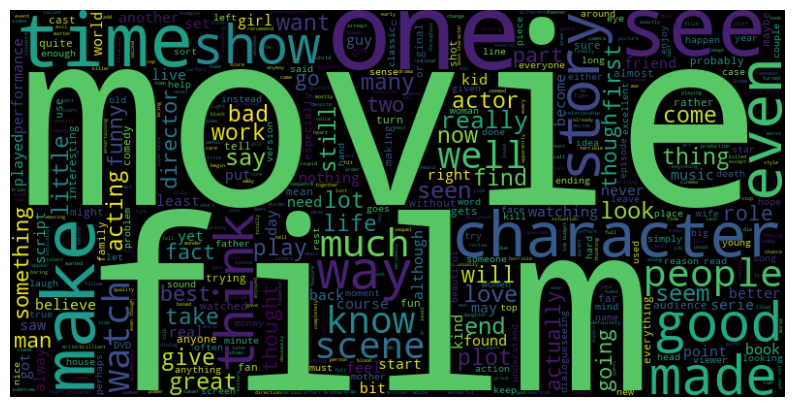

In [21]:
def display_cloud(data, save_as):
    plt.figure(figsize=(10,10))
    wc = WordCloud(stopwords=STOPWORDS, 
                    background_color="black", contour_width=2,
                   max_words=2000, max_font_size=256, width=800, height=400,
                   random_state=42)
    wc.generate(' '.join(data))
    plt.tight_layout(pad=0)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.savefig(save_as, facecolor='black', bbox_inches='tight')
    plt.show()

display_cloud(data['review'], './images/plots/all_reviews_word_cloud.jpg')

Total Counts of both sets sentiment
positive    25000
negative    21500
Name: count, dtype: int64


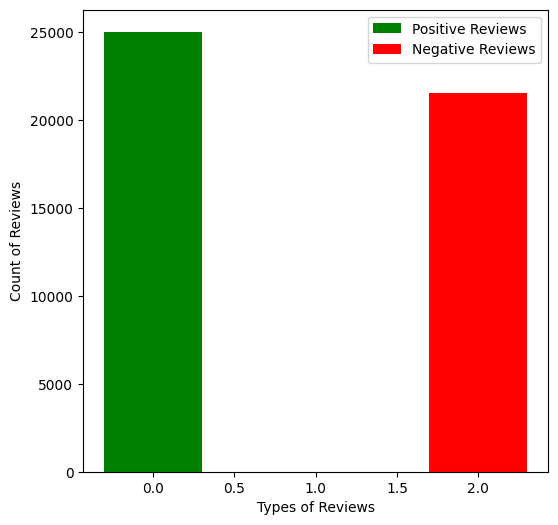

In [12]:
good_reviews = data[data['sentiment'] == 'positive']['review']
bad_reviews = data[data['sentiment'] == 'negative']['review']

count=data['sentiment'].value_counts()
print('Total Counts of both sets'.format(),count)

print("==============")
#Creating a function to plot the counts using matplotlib
def plot_counts(count_good,count_bad):
    plt.rcParams['figure.figsize']=(6,6)
    plt.bar(0,count_good,width=0.6,label='Positive Reviews',color='Green')
    plt.legend()
    plt.bar(2,count_bad,width=0.6,label='Negative Reviews',color='Red')
    plt.legend()
    plt.ylabel('Count of Reviews')
    plt.xlabel('Types of Reviews')
    plt.show()
    
count_good = data[data['sentiment'] == 'positive']
count_bad = data[data['sentiment'] == 'negative']
plot_counts(len(count_good),len(count_bad))

## Transforming the Data

In [10]:
def remove_stopwords(text):
    words = word_tokenize(text)
    
    stop_words = set(stopwords.words('english'))

    filtered_words = [word for word in words if word not in stop_words]
    
    filtered_text = ' '.join(filtered_words)
    
    return filtered_text

data['clean_review'] = data['clean_review'].apply(remove_stopwords)

In [11]:
# Remove numbers
data['clean_review'] = data['clean_review'].replace(to_replace=r'\d', value='', regex=True)

data.head()

,review,sentiment,clean_review
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me. The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word. It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away. I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.",positive,one reviewers mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far away would say main appeal show due fact goes shows would dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz mess around first episode ever saw struck nasty surreal could say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards wholl sold nickel inmates wholl kill order get away well mannered middle class inmates turned prison bitches due lack street skills prison experience watching oz may become comfortable uncomfortable viewingthats get touch darker side
1,"A wonderful little production. The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.",positive,wonderful little production filming technique unassuming oldtimebbc fashion gives comforting sometimes discomforting 

In [12]:
data['clean_review'] = data['clean_review'].apply(lambda x: x.lower() if isinstance(x, str) else x)

data.head()

,review,sentiment,clean_review
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me. The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word. It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away. I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.",positive,one reviewers mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far away would say main appeal show due fact goes shows would dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz mess around first episode ever saw struck nasty surreal could say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards wholl sold nickel inmates wholl kill order get away well mannered middle class inmates turned prison bitches due lack street skills prison experience watching oz may become comfortable uncomfortable viewingthats get touch darker side
1,"A wonderful little production. The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.",positive,wonderful little production filming technique unassuming oldtimebbc fashion gives comforting sometimes discomforting 

### Lemmatization

In [13]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Function to lemmatize a list of tokens
def lemmatize_tokens(doc):
    return [token.lemma_ for token in doc]

def preprocess_pipe(docs):
    preproc_pipe = []

    for doc in nlp.pipe(docs, batch_size=32, n_process=3):
        preproc_pipe.append(" ".join(lemmatize_tokens(doc)))


    return preproc_pipe

In [14]:
data['lemmatization'] = preprocess_pipe(data['clean_review'])

data.head()

,review,sentiment,clean_review,lemmatization
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me. The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word. It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away. I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.",positive,one reviewers mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far away would say main appeal show due fact goes shows would dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz mess around first episode ever saw struck nasty surreal could say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards wholl sold nickel inmates wholl kill order get away well mannered middle class inmates turned prison bitches due lack street skills prison experience watching oz may become comfortable uncomfortable viewingthats get touch darker side,one reviewer mention watch oz episode hook right exactly happen first thing strike oz brutality unflinche scene violence set right word go trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use word call oz nickname give oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inward privacy high agenda em city home manyaryans muslim gangstas latinos christians italian irish moreso scuffle death stare dodgy dealing shady agreement never far away would say main appeal show due fact go show would dare forget pretty picture paint mainstream audience forget charm forget romanceoz mess around first episode ever see strike nasty surreal could say ready watch develop taste oz get accustom high level graphic violence violence injustice crook guard who ll sell nickel inmate who ll kill order get away well mannered middle class inmate turn prison bitch due lack street skill prison experience watch oz may become comfortable uncomfortable viewingthat get touch dark side
1,"A wond

### Count Vectorizer And TF-IDF

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from joblib import dump

# coun_vect = CountVectorizer(lowercase=False, max_features=20000, ngram_range=(1,3), min_df=0.2, max_df=0.8)

# X_cv = coun_vect.fit_transform(data['lemmatization'])

tfidf = TfidfVectorizer(max_features=50000, ngram_range=(1,2), min_df=0.0, max_df=1.0, use_idf=True)

X_tf_idf = tfidf.fit_transform(data['lemmatization'])

vectorizer_filename = './models/basic_models/tfidf_vectorizer.joblib'
dump(tfidf, vectorizer_filename)

y = data['sentiment']

In [21]:
def evaluate_model(X_train, y_train,  X_test, y_test, model, experiment_id, run_name):

    with mlflow.start_run(experiment_id=experiment_id, run_name=run_name):
        model.fit(X_train, y_train)

        # Evaluate model
        y_pred = model.predict(X_test)

        cr = classification_report(y_test, y_pred, output_dict=True)

        cm = confusion_matrix(y_test, y_pred)

        ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_).plot()

        tn, fp, fn, tp = cm.ravel()

        mlflow.log_metric("True Positives", tp)
        mlflow.log_metric("True Negatives", tn)
        mlflow.log_metric("False Positives", fp)
        mlflow.log_metric("False Negatives", fn)

        print("Classification Report:")
        print(classification_report(y_test, y_pred))

        # Log model parameters
        mlflow.log_params(model.get_params())

        # Log model metrics
        mlflow.log_metric("Accuracy", cr.pop("accuracy"))
        for class_or_avg, metrics_dict in cr.items():
            for metric, value in metrics_dict.items():
                if "support" not in metric:
                    if class_or_avg == "0":
                        mlflow.log_metric('negative_' + metric, value)
                    if class_or_avg == "1":
                        mlflow.log_metric('positive_' + metric, value)
                    else:
                        mlflow.log_metric(class_or_avg + '_' + metric, value)

        mlflow.sklearn.log_model(model, model.__class__.__name__)

        mlflow.end_run()


# Naive Bayes

In [22]:
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_cv, y, test_size=0.2, random_state=42)

print('Train size:', X_train_cv.shape)
print('Test size:', X_test_cv.shape)

Train size: (37200, 42)
Test size: (9300, 42)


Naive-Bayes score (CV)
Classification Report:
              precision    recall  f1-score   support

    negative       0.70      0.66      0.68      4292
    positive       0.72      0.76      0.74      5008

    accuracy                           0.71      9300
   macro avg       0.71      0.71      0.71      9300
weighted avg       0.71      0.71      0.71      9300



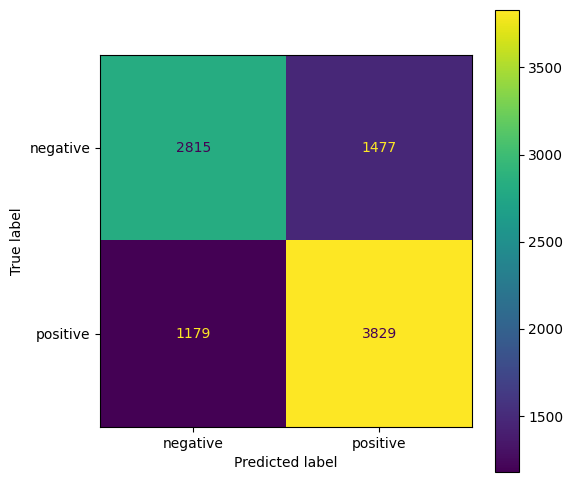

In [23]:
multinomial_model = MultinomialNB()

print("Naive-Bayes score (CV)")
evaluate_model(X_train_cv.toarray(), y_train_cv, X_test_cv.toarray(), y_test_cv, multinomial_model, experiment_id, "Naive-Bayes score (CV)")

In [15]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tf_idf, y, test_size=0.2, random_state=42)

print('Train size:', X_train_tfidf.shape)
print('Test size:', X_test_tfidf.shape)

Train size: (37200, 25000)
Test size: (9300, 25000)


Naive-Bayes score (TF-IDF)
Classification Report:
              precision    recall  f1-score   support

    negative       0.89      0.83      0.86      4292
    positive       0.86      0.91      0.89      5008

    accuracy                           0.87      9300
   macro avg       0.87      0.87      0.87      9300
weighted avg       0.87      0.87      0.87      9300



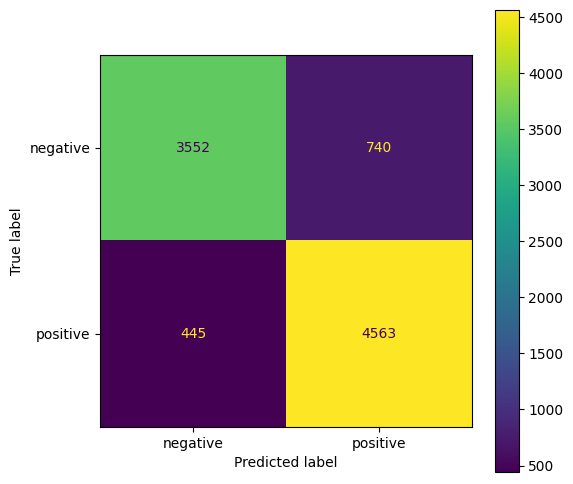

In [25]:
multinomial_model = MultinomialNB()

print("Naive-Bayes score (TF-IDF)")
evaluate_model(X_train_tfidf, y_train_tfidf, X_test_tfidf, y_test_tfidf, multinomial_model, experiment_id, "Naive-Bayes score (TF-IDF)")

# Random Forest Classifier

RandomForest Classifier score (CV)
Classification Report:
              precision    recall  f1-score   support

    negative       0.74      0.61      0.67      4292
    positive       0.71      0.82      0.76      5008

    accuracy                           0.72      9300
   macro avg       0.73      0.71      0.71      9300
weighted avg       0.72      0.72      0.72      9300



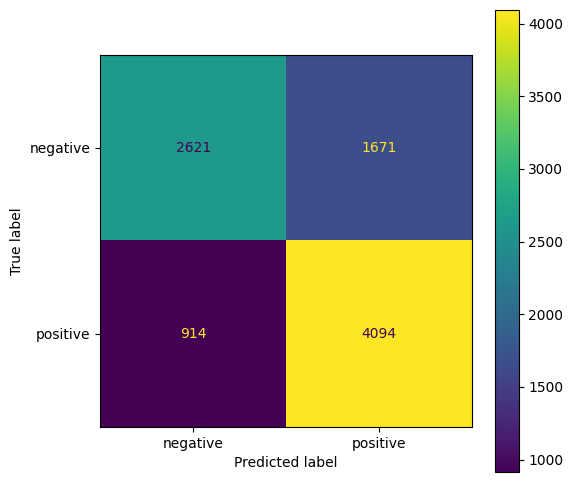

In [26]:
rfc = RandomForestClassifier(max_features='sqrt',
                             max_depth=15,
                             n_estimators=500,
                             min_samples_split=5,
                             min_samples_leaf=1,
                             bootstrap=True)

print("RandomForest Classifier score (CV)")
evaluate_model(X_train_cv, y_train_cv, X_test_cv, y_test_cv, rfc, experiment_id, "RandomForest Classifier score (CV)")

RandomForest Classifier score (TF-IDF)
Classification Report:
              precision    recall  f1-score   support

    negative       0.93      0.64      0.76      4292
    positive       0.76      0.96      0.85      5008

    accuracy                           0.81      9300
   macro avg       0.84      0.80      0.80      9300
weighted avg       0.84      0.81      0.81      9300



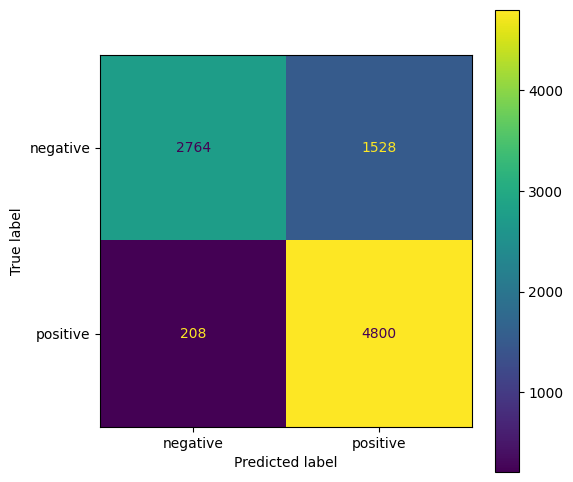

In [27]:
rfc = RandomForestClassifier(max_features='sqrt',
                             max_depth=15,
                             n_estimators=1000,
                             min_samples_split=5,
                             min_samples_leaf=1,
                             bootstrap=True)

print("RandomForest Classifier score (TF-IDF)")
evaluate_model(X_train_tfidf, y_train_tfidf, X_test_tfidf, y_test_tfidf, rfc, experiment_id, "RandomForest Classifier score (TF-IDF)")

# Logistic Regression

In [28]:
from sklearn.linear_model import LogisticRegression

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10], 
    'penalty': ['l1', 'l2'],          
    'solver': ['liblinear', 'saga'] 
}

logistic_regression_model = LogisticRegression()

grid_search = GridSearchCV(logistic_regression_model, param_grid, cv=5)
grid_search.fit(X_train_cv, y_train_cv)

best_params = grid_search.best_params_
print("Best Hyperparameters (Logistic Regression):", best_params)

Best Hyperparameters (Logistic Regression): {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}


LogisticRegression score (CV)
Classification Report:
              precision    recall  f1-score   support

    negative       0.73      0.63      0.68      4292
    positive       0.72      0.80      0.76      5008

    accuracy                           0.72      9300
   macro avg       0.73      0.72      0.72      9300
weighted avg       0.72      0.72      0.72      9300



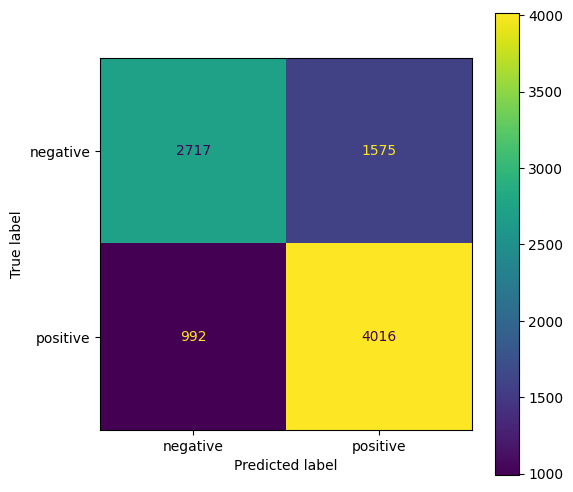

In [29]:
lr = LogisticRegression(C=best_params['C'],
                        penalty=best_params['penalty'],
                        solver=best_params['solver'])

print("LogisticRegression score (CV)")
evaluate_model(X_train_cv, y_train_cv, X_test_cv, y_test_cv, lr, experiment_id, "LogisticRegression score (CV)")

In [30]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10], 
    'penalty': ['l1', 'l2'],          
    'solver': ['liblinear', 'saga'] 
}

logistic_regression_model = LogisticRegression()

grid_search = GridSearchCV(logistic_regression_model, param_grid, cv=5)
grid_search.fit(X_train_tfidf, y_train_tfidf)

best_params = grid_search.best_params_
print("Best Hyperparameters (Logistic Regression):", best_params)

Best Hyperparameters (Logistic Regression): {'C': 10, 'penalty': 'l2', 'solver': 'saga'}


LogisticRegression score (TF-IDF)
Classification Report:
              precision    recall  f1-score   support

    negative       0.90      0.88      0.89      4292
    positive       0.90      0.92      0.91      5008

    accuracy                           0.90      9300
   macro avg       0.90      0.90      0.90      9300
weighted avg       0.90      0.90      0.90      9300



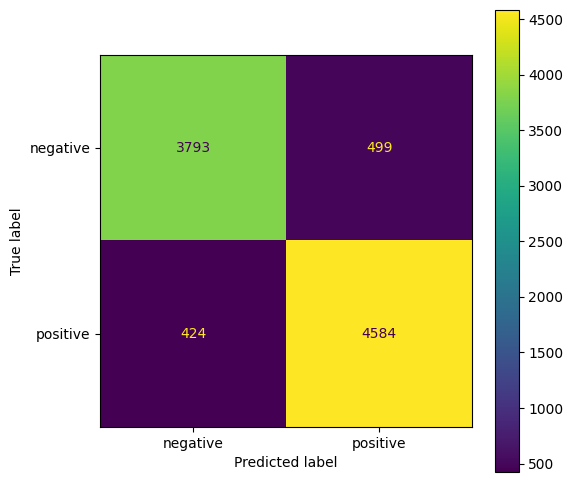

In [31]:
lr = LogisticRegression(C=best_params['C'],
                        penalty=best_params['penalty'],
                        solver=best_params['solver'])

print("LogisticRegression score (TF-IDF)")
evaluate_model(X_train_tfidf, y_train_tfidf, X_test_tfidf, y_test_tfidf, lr, experiment_id, "LogisticRegression score (TF-IDF)")

In [26]:
from joblib import load

lr = load('./models/basic_models/logistic_regression_model_tfidf.joblib')

coefficients = lr.coef_[0]

tfidf = load('./models/basic_models/tfidf_vectorizer.joblib')

# Get feature names from the TF-IDF vectorizer
feature_names = tfidf.get_feature_names_out()

# Create a DataFrame to store coefficients and corresponding feature names
coefficients_df = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})

# Sort the DataFrame by coefficients to identify the most impactful words
most_impactful_words = coefficients_df.sort_values(by='coefficient', ascending=False)

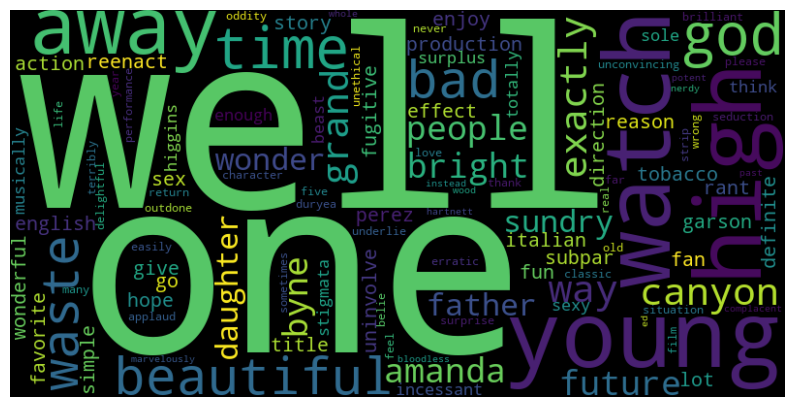

In [28]:
top_100_features = most_impactful_words['feature'].head(80)

# Remove 'bad' if it exists in the top 100 features
top_100_features = top_100_features[top_100_features != 'bad']

display_cloud(top_100_features, './images/plots/good_word_cloud.jpg')

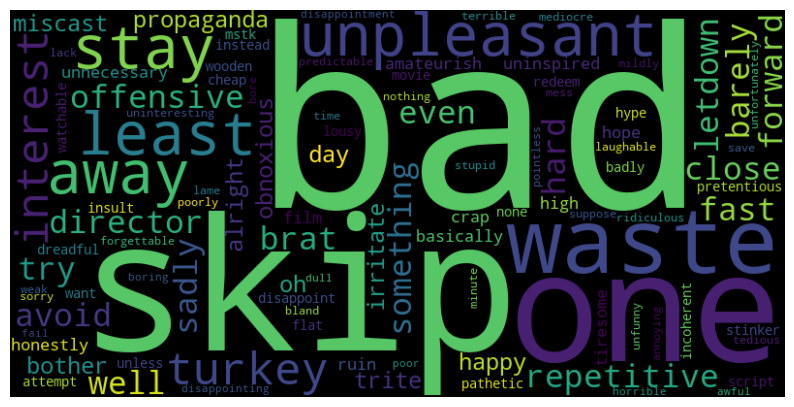

In [48]:
display_cloud(most_impactful_words['feature'].tail(100), './images/plots/bad_word_cloud.jpg')

# XGBoost Classifier

In [32]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.05],
    'n_estimators': [100, 200, 300, 400, 500],
    'gamma': [0, 0.1, 0.2]
}

#tree_method='gpu_hist'
grid_search_xgb = GridSearchCV(estimator=XGBClassifier(tree_method='hist', device='cuda'), param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1)

label_encoder = LabelEncoder()

y_train_cv_encoded = label_encoder.fit_transform(y_train_cv)

grid_search_xgb.fit(X_train_cv, y_train_cv_encoded)

best_params = grid_search_xgb.best_params_
print("Best Hyperparameters (XGBoost):", best_params)

Best Hyperparameters (XGBoost): {'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}


XGBoosting score (CV)
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.60      0.66      4292
           1       0.71      0.82      0.76      5008

    accuracy                           0.72      9300
   macro avg       0.72      0.71      0.71      9300
weighted avg       0.72      0.72      0.71      9300



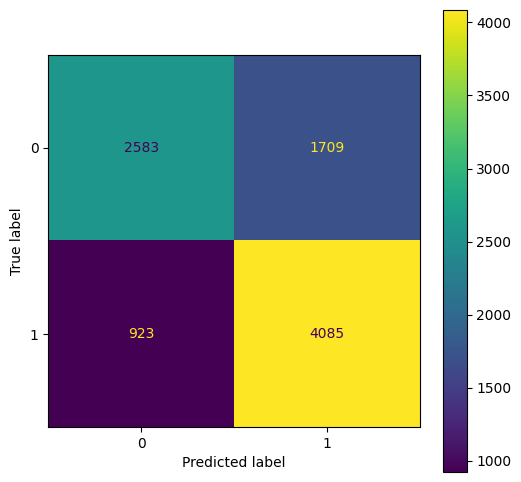

In [33]:
xgb = XGBClassifier(max_depth=best_params['max_depth'],
                    learning_rate=best_params['learning_rate'],
                    n_estimators=best_params['n_estimators'],
                    gamma=best_params['gamma'])

print("XGBoosting score (CV)")
evaluate_model(X_train_cv, label_encoder.fit_transform(y_train_cv), X_test_cv, label_encoder.fit_transform(y_test_cv), xgb, experiment_id, "XGBoosting score (CV)")

In [40]:
grid_search_xgb.fit(X_train_tfidf, label_encoder.fit_transform(y_train_tfidf))

best_params = grid_search_xgb.best_params_
print("Best Hyperparameters (XGBoost):", best_params)

Best Hyperparameters (XGBoost): {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}


In [42]:
xgb = XGBClassifier(max_depth=best_params['max_depth'],
                    learning_rate=best_params['learning_rate'],
                    n_estimators=best_params['n_estimators'],
                    gamma=best_params['gamma'])

print("XGBoosting score (TF-IDF)")
evaluate_model(X_train_tfidf, label_encoder.fit_transform(y_train_tfidf), X_test_tfidf, label_encoder.fit_transform(y_test_tfidf), xgb, experiment_id, "XGBoosting score (TF-IDF)")

XGBoosting score (TF-IDF)


MlflowException: API request to http://192.168.66.221:20002/api/2.0/mlflow/runs/create failed with timeout exception HTTPConnectionPool(host='192.168.66.221', port=20002): Max retries exceeded with url: /api/2.0/mlflow/runs/create (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x0000025B1E4F5400>, 'Connection to 192.168.66.221 timed out. (connect timeout=120)')). To increase the timeout, set the environment variable MLFLOW_HTTP_REQUEST_TIMEOUT (default: 120, type: int) to a larger value.

# BERT

In [35]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

path = './models/bert-base-cased'
bert_model = AutoModelForSequenceClassification.from_pretrained(path, local_files_only=True)

Testing BERT model on my input.

In [36]:
import torch.nn.functional as F

input_sentence = "This movie was really awful."

# Tokenize the input sentence
inputs = tokenizer(input_sentence, 
                   return_tensors="pt")
# Perform inference
with torch.no_grad():
    outputs = bert_model.forward(**inputs, output_hidden_states=True)

probabilities = F.softmax(outputs.logits, dim=1)

# Check if the probability at index 0 is higher
if probabilities[0][0] > probabilities[0][1]:
    print("Negative statement")
else:
    print("Positive statement")

tensor([[9.9990e-01, 1.0365e-04]])
Negative statement


In [16]:
from joblib import dump
import json  
from sklearn.linear_model import LogisticRegression

with open('./models/basic_models/best_params_Logistic_Regression_(TF-IDF).json') as json_file:
        best_params = json.load(json_file)

best_params = dict(best_params)

lr = LogisticRegression(**best_params)

lr.fit(X_train_tfidf, y_train_tfidf)

model_filename = './models/basic_models/logistic_regression_model_tfidf.joblib'
dump(lr, model_filename)


['./models/basic_models/logistic_regression_model_tfidf.joblib']